# Case Study: COVID-19 Stress Test

In the earlier [analysis on credit spreads](credit_spread_analysis.ipynb), one of the most recent extreme periods of credit spreads widening was observed during 2020, which coincides with the COVID-19 pandemic. This period introduces a unique stress event, presenting sharp economic contraction, extreme market volatility, and unprecedented fiscal and monetary intervention. 

Unlike in previous crises, such as the 2008 financial crisis, the COVID-19 shock was met with fast and large-scale policy responses aiming to stabilise financial markets and containing systemic risk. This makes COVID-19 an interesting case for evaluating how models trained on historical data would behave under a structurally different stress regime.

In this case study, a linear regression model trained on data from 2000 - 2019 is applied to the COVID-19 period. The objective is not to focus on the models forecasting ability, but rather assess how well relationships learned from historical regimes generalise to an extreme and unexpected stress event, and observe how the model behaves when those relationships begin to break down.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/credit_spread.csv', index_col=0, parse_dates=True)
df.head()

,spread,unrate,fedfunds,yield_curve,vix_monthly,sp500_monthly,vix_lag1,fedfunds_delta,inflation_yoy,production_yoy
2000-01-01,1.67,4.0,5.45,0.22,23.202000,-0.041753,22.159091,0.15,0.027930,90.5380
2000-02-01,1.77,4.1,5.73,-0.09,23.595500,-0.020108,23.202000,0.28,0.032180,90.8239
2000-03-01,2.11,4.0,5.85,-0.27,22.718261,0.096720,23.595500,0.12,0.037621,91.1504
2000-04-01,2.41,3.8,6.02,-0.41,27.164211,-0.035552,22.718261,0.17,0.030139,91.6989
2000-05-01,2.46,4.0,6.27,-0.37,26.373182,-0.021915,27.164211,0.25,0.031325,91.9499


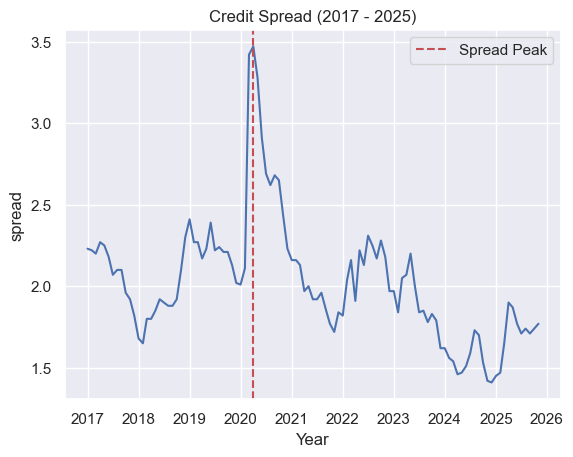

In [3]:
covid_period = df.loc['2017':]

sns.set_theme()
sns.lineplot(covid_period['spread'])
plt.title('Credit Spread (2017 - 2025)')
plt.axvline(covid_period['spread'].idxmax(), color='r', ls='--', label='Spread Peak')
plt.xlabel('Year')
plt.legend()
plt.show()

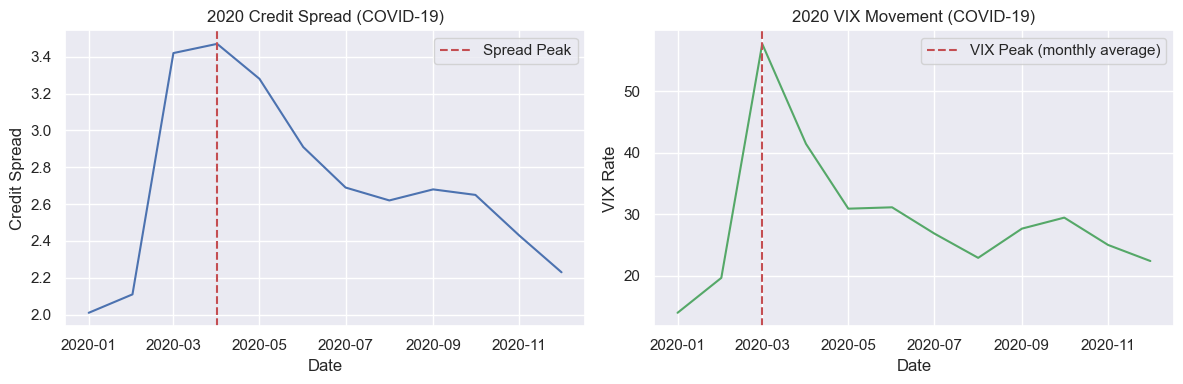

In [4]:
covid_2020 = covid_period.loc['2020']

# credit spreads & vix movements in 2020 (covid regime)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(covid_2020.index, covid_2020['spread'])
plt.axvline(covid_period['spread'].idxmax(), color='r', ls='--', label='Spread Peak')
plt.title('2020 Credit Spread (COVID-19)')
plt.xlabel('Date')
plt.ylabel('Credit Spread')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(covid_2020.index, covid_2020['vix_monthly'], color='g')
plt.axvline(covid_period['vix_monthly'].idxmax(), color='r', ls='--', label='VIX Peak (monthly average)')
plt.title('2020 VIX Movement (COVID-19)')
plt.xlabel('Date')
plt.ylabel('VIX Rate')
plt.legend()

plt.tight_layout()
plt.show()

## Stress Test: Linear Regression

In [5]:
# training set
X_train = df.loc['2000': '2019'].drop(columns='spread')
y_train = df.loc['2000': '2019']['spread']

# testing set
X_test = df.loc['2020'].drop(columns='spread')
y_test = df.loc['2020']['spread']

X_train.head()

,unrate,fedfunds,yield_curve,vix_monthly,sp500_monthly,vix_lag1,fedfunds_delta,inflation_yoy,production_yoy
2000-01-01,4.0,5.45,0.22,23.202000,-0.041753,22.159091,0.15,0.027930,90.5380
2000-02-01,4.1,5.73,-0.09,23.595500,-0.020108,23.202000,0.28,0.032180,90.8239
2000-03-01,4.0,5.85,-0.27,22.718261,0.096720,23.595500,0.12,0.037621,91.1504
2000-04-01,3.8,6.02,-0.41,27.164211,-0.035552,22.718261,0.17,0.030139,91.6989
2000-05-01,4.0,6.27,-0.37,26.373182,-0.021915,27.164211,0.25,0.031325,91.9499


In [6]:
# standardise data
covid_scaler = StandardScaler()
X_train = covid_scaler.fit_transform(X_train)
X_test = covid_scaler.transform(X_test)

In [7]:
# model
covid_model = LinearRegression()

# training
covid_model.fit(X_train, y_train)

# predictions
y_pred = covid_model.predict(X_test)

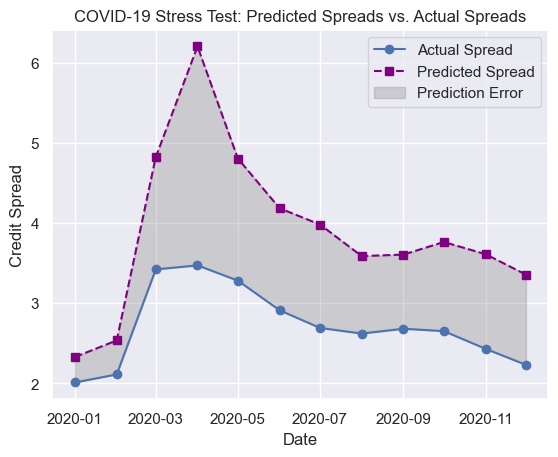

In [8]:
# plot predictions

# actual spread
plt.plot(y_test.index, y_test, lw=1.5, marker='o', label='Actual Spread')
# predicted spread
plt.plot(y_test.index, y_pred, color='purple', ls='--', lw=1.5, marker='s', label='Predicted Spread')
# styling
plt.title('COVID-19 Stress Test: Predicted Spreads vs. Actual Spreads')
plt.fill_between(y_test.index, y_test, y_pred, color='grey', alpha=0.3, label='Prediction Error')
plt.xlabel('Date')
plt.ylabel('Credit Spread')
plt.legend(loc='best')
plt.savefig('figures/stress_test_result.png')
plt.show()
plt.close()

**Findings**

The graph shows that the model grossly overestimates credit spreads during the COVID-19 stress test. While credit spreads actually peaked to around 3.5 in March, the model predicted spreads to peak ay 6 in the same month. This pattern of overestimations continues throughout the year, with the model consistently predicting higher spreads than what is observed 

Despite the inaccuracy in predicted spread values, the model wis still able to follow the overall trend of spreads reasonably well. Although the predicted peak is delayed by around one month, it still occurs within a similar time window. This behaviour continues throughout the period, where the model also predicts spreads to fall and stabilise around the same time that the true spreads begin to recover. Overall, while the model struggles with the magnitude of spread movements, it is still able to capture directional movements relatively well (i.e., whether spreads are widening or tightening). 

The discrepancy between the predicted and actual spreads is likely influenced by what the model had learned from historical regimes. Over the past 26 years, there have been four major periods where credit spreads widened significantly:

- 2001: Dot Com
- 2008: Financial crisis/ recession
- 2016: Period of heightened uncertainty (U.S. election, Brexit, Gas markets drop, etc.)
- 2020: COVID-19

Drawing back to the coefficients and correlations relationships found in the [initial analysis](credit_spread_analysis.ipynb), we observed that during stressed periods, relationships between spreads and key macro-financial variables become much stronger. For example, during stress events, VIX tends to spike sharply and unemployment tends to rise, both of which historically coincide with spreads widening in proportion. This could serve to explain why the model overestimates spreads during the COVID-19 period: the model appears to extrapolate these historical stress relationships and implicitly assumes that spreads *should* widen similarly to past crises (especially 2008). 

However, the COVID-19 period was structurally different from previous crises. Learning from events like the 2008 financial crisis, governments, central banks, and financial institutions were better prepared. As a result, large-scale monetary an fiscal interventions were introduced quickly to stabilise markets and contain potential damage. Since the model does not include policy response as a direct feature, it is unable to account for these interventions and instead predicts spreads widening closer to what was historically observed during earlier crisis. In other words, the model likely predicted what spreads *could* have been, if these policies or intervention were not introduced.

## Conclusion

In this COVID-19 stress test:
- Built a linear regression model trained on data from 2000 - 2019, stress-tested on the 2020 COVID-19 period.
- Observed the model to *overestimate* spread values.
    - While the model struggled to predict the magnitude of spread widening, it was still able to pick up on the overall directional movement of spreads.
- Theorised that historical stress events (e.g., 2008 fincncial crisis) influened the models behaviour.
    - This could indicate that model likely predicted what spreads *could* looked like under similar levels of stress, assuming limited interventions from governmetns, central banks or financial instituions.

**Future work:**
- Explore credit spread forecasting using other ML approaches (e.g., tree-based models or gradient boosting).
- Inestigate how credit spreads are applied to credit pricing.